tiny yolo 3 for single channel data trained on the provided data only 


I fillowed this structure: 
https://gitlab.com/ismobaga/keras-yolo3/blob/master/yolov3-tiny.cfg


In [1]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import pickle
from utils import data_gen
from preprocessing import parse_lables, new_img_ann
import numpy as np
import json
import copy
import cv2

# global IMAGE_H, IMAGE_W
# import os, cv2
# from utils import BatchGenerator
# from utils import WeightReader, decode_netout, draw_boxes

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

Using TensorFlow backend.


In [2]:
LABELS = ['1', '2']
# IMAGE_H, IMAGE_W = 416, 416
IMAGE_H, IMAGE_W =  480,640
GRID_H, GRID_W = 15 , 20
BOX              = 5
CLASS            = len(LABELS)

CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

TRESHOLD = 0.3
# OBJ_THRESHOLD    = 0.3#0.5
# CLASS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.232813,0.154167, 0.303125,0.202083, 0.440625,0.293750, 0.612500,0.408333, 0.799219,0.532292]

SCALE_NOOB  = 1.0
SCALE_OBJECT     = 5.0
SCALE_COOR      = 1.0
SCALE_CLASS     = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [3]:
def aug_img(train_instance):
    path = train_instance['filename']
    all_obj = copy.deepcopy(train_instance['object'][:])
    img = cv2.imread(path)
    h, w, c = img.shape

    # scale the image
    scale = np.random.uniform() / 10. + 1.
    img = cv2.resize(img, (0,0), fx = scale, fy = scale)

    # translate the image
    max_offx = (scale-1.) * w
    max_offy = (scale-1.) * h
    offx = int(np.random.uniform() * max_offx)
    offy = int(np.random.uniform() * max_offy)
    img = img[offy : (offy + h), offx : (offx + w)]

    # flip the image
    flip = np.random.binomial(1, .5)
    if flip > 0.5: img = cv2.flip(img, 1)

    # re-color
    t  = [np.random.uniform()]
    t += [np.random.uniform()]
    t += [np.random.uniform()]
    t = np.array(t)

    img = img * (1 + t)
    img = img / (255. * 2.)

    # resize the image to standard size
#     img = cv2.resize(img, (IMAGE_H, IMAGE_W))
#     img = img[:,:,::-1]

    # fix object's position and size
    for obj in all_obj:
        for attr in ['xmin', 'xmax']:
            obj[attr] = int(obj[attr] * scale - offx)
            obj[attr] = int(obj[attr] * float(IMAGE_W) / w)
            obj[attr] = max(min(obj[attr], IMAGE_W), 0)

        for attr in ['ymin', 'ymax']:
            obj[attr] = int(obj[attr] * scale - offy)
            obj[attr] = int(obj[attr] * float(IMAGE_H) / h)
            obj[attr] = max(min(obj[attr], IMAGE_H), 0)

        if flip > 0.5:
            xmin = obj['xmin']
            obj['xmin'] = IMAGE_W - obj['xmax']
            obj['xmax'] = IMAGE_W - xmin

    return  img[:,:,1].reshape((image.shape[0],image.shape[1],1)) , all_obj

In [4]:
# wt_path = 'yolo.weights'                      
img_dir = 'data/train/'
train_ann = 'data/train_ann.json'

val_img_dir = 'data/val/'
val_ann = 'data/val_ann.json'

In [5]:
with open(train_ann) as f:
    anns = json.load(f)

{u'width': 640, u'object': [{u'ymax': 256, u'label': u'2', u'box_height': 508, u'box_width': 253, u'xmax': 506, u'xmin': -2, u'ymin': 3}, {u'ymax': 366, u'label': u'1', u'box_height': 382, u'box_width': 191, u'xmax': 458, u'xmin': 76, u'ymin': 175}], u'filename': u'data/depth/seq0_0001_0.pgm', u'height': 480}
(480, 640, 3)
(480, 640)


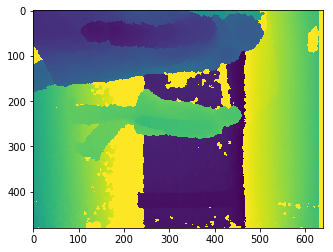

In [6]:
print anns[1]

image = cv2.imread(anns[1]['filename'])
print  image.shape

plt.imshow(image)

tmp= image[:,:,1]
plt.imshow(tmp)
print  tmp.shape


In [7]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [8]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 1))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [9]:
model = Sequential()

# Layer 1
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(IMAGE_H, IMAGE_W,1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2 - 5
for i in range(0,4):
    model.add(Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

# Layer 7 

model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
    
# Layer 8     
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

# Layer 9
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

# Layer 10     
model.add(Conv2D(255, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('linear'))





# Layer 11
model.add(Conv2D(BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('linear'))
model.add(Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS)))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 480, 640, 16)      144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 480, 640, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 480, 640, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 240, 320, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 320, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 240, 320, 32)      128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 240, 320, 32)      0         
__________

In [11]:
# connecting_layer = model.layers[-4].output

# top_model = Conv2D(BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal') (connecting_layer)
# top_model = Activation('linear') (top_model)
# top_model = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS)) (top_model)

In [12]:
def custom_loss(y_true, y_pred):
    ### Adjust prediction
    # adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
    
    # adjust w and h
    pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
    
    # adjust probability
    pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
    
    y_pred = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_prob], 4)
    print("Y_pred shape: {}".format(y_pred.shape))
    
    ### Adjust ground truth
    # adjust x and y
    center_xy = .5*(y_true[:,:,:,:,0:2] + y_true[:,:,:,:,2:4])
    center_xy = center_xy / np.reshape([(float(IMAGE_W)/GRID_W), (float(IMAGE_H)/GRID_H)], [1,1,1,1,2])
    true_box_xy = center_xy - tf.floor(center_xy)
    
    # adjust w and h
    true_box_wh = (y_true[:,:,:,:,2:4] - y_true[:,:,:,:,0:2])
    true_box_wh = tf.sqrt(true_box_wh / np.reshape([float(IMAGE_W), float(IMAGE_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
    pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
    pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
    
    true_tem_wh = tf.pow(true_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    true_box_area = true_tem_wh[:,:,:,:,0] * true_tem_wh[:,:,:,:,1]
    true_box_ul = true_box_xy - 0.5 * true_tem_wh
    true_box_bd = true_box_xy + 0.5 * true_tem_wh
    
    intersect_ul = tf.maximum(pred_box_ul, true_box_ul) 
    intersect_br = tf.minimum(pred_box_bd, true_box_bd)
    intersect_wh = intersect_br - intersect_ul
    intersect_wh = tf.maximum(intersect_wh, 0.0)
    intersect_area = intersect_wh[:,:,:,:,0] * intersect_wh[:,:,:,:,1]
    
    iou = tf.truediv(intersect_area, true_box_area + pred_box_area - intersect_area)
    best_box = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box = tf.to_float(best_box)
    true_box_conf = tf.expand_dims(best_box * y_true[:,:,:,:,4], -1)
    
    # adjust confidence
    true_box_prob = y_true[:,:,:,:,5:]
    
    y_true = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_prob], 4)
    print("Y_true shape: {}".format(y_true.shape))
    #y_true = tf.Print(y_true, [true_box_wh], message='DEBUG', summarize=30000)    
    
    ### Compute the weights
    weight_coor = tf.concat(4 * [true_box_conf], 4)
    weight_coor = SCALE_COOR * weight_coor
    
    weight_conf = SCALE_NOOB * (1. - true_box_conf) + SCALE_OBJECT * true_box_conf
    
    weight_prob = tf.concat(CLASS * [true_box_conf], 4) 
    weight_prob = SCALE_CLASS * weight_prob 
    
    weight = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    print("Weight shape: {}".format(weight.shape))
    
    ### Finalize the loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight
    loss = tf.reshape(loss, [-1, GRID_W*GRID_H*BOX*(4 + 1 + CLASS)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

In [13]:
def data_gen(img_anns, batch_size):
    num_img = len(img_anns)
    shuffled_indices = np.random.permutation(np.arange(num_img))
    l_bound = 0
    r_bound = batch_size if batch_size < num_img else num_img

    while True:
        if l_bound == r_bound:
            l_bound  = 0
            r_bound = batch_size if batch_size < num_img else num_img
            shuffled_indices = np.random.permutation(np.arange(num_img))

        batch_size = r_bound - l_bound
        currt_inst = 0
        x_batch = np.zeros((batch_size, IMAGE_H, IMAGE_W, 1))
        y_batch = np.zeros((batch_size, GRID_H, GRID_W, BOX, 5+CLASS))

        for index in shuffled_indices[l_bound:r_bound]:
            train_instance = img_anns[index]

            # augment input image and fix object's position and size
            img, all_obj = aug_img(train_instance)
            #for obj in all_obj:
            #    cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (1,1,0), 3)
            #plt.imshow(img); plt.show()

            # construct output from object's position and size
            for obj in all_obj:
                box = []
                center_x = .5*(obj['xmin'] + obj['xmax']) #xmin, xmax
                center_x = center_x / (float(IMAGE_W) / GRID_W)
                center_y = .5*(obj['ymin'] + obj['ymax']) #ymin, ymax
                center_y = center_y / (float(IMAGE_H) / GRID_H)

                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))

                if grid_x < GRID_W and grid_y < GRID_H:
                    obj_idx = int(obj['label'])-1
                    box = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']]

                    y_batch[currt_inst, grid_y, grid_x, :, 0:4]        = BOX * [box]
                    y_batch[currt_inst, grid_y, grid_x, :, 4  ]        = BOX * [1.]
                    y_batch[currt_inst, grid_y, grid_x, :, 5: ]        = BOX * [[0.]*CLASS]
                    y_batch[currt_inst, grid_y, grid_x, :, 5+obj_idx] = 1.0

            # concatenate batch input from the image
            x_batch[currt_inst] = img
            currt_inst += 1

            del img, all_obj

        yield x_batch, y_batch

        l_bound  = r_bound
        r_bound = r_bound + batch_size
        if r_bound > num_img: r_bound = num_img


# In[ ]:

In [14]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

In [ ]:
sgd = SGD(lr=0.001, decay=0.0005, momentum=0.9)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=sgd)
model.fit_generator(data_gen(anns, BATCH_SIZE), 
                    int(len(anns)/BATCH_SIZE), 
                    epochs = 10, 
                    verbose = 2,
                    callbacks = [early_stop, checkpoint],
                    max_q_size = 3)

Y_pred shape: (?, 15, 20, 5, 7)
Y_true shape: (?, 15, 20, 5, ?)
Weight shape: (?, 15, 20, 5, 7)


/Users/vira/Documents/Machine Learning/blackai-challenge/.env/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 117, epochs=10, callbacks=[<keras.ca..., max_queue_size=3, verbose=2)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
